# Testing RBF vs Linear SVM


## Two class case

### 1. Import

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.multiclass import OneVsRestClassifier

from sklearn.inspection import permutation_importance

from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap, BoundaryNorm

from sklearn.metrics import average_precision_score
from functools import partial



# Ladda data
df = pd.read_excel("Project SF2935.xlsx", sheet_name="Wine data")


### 2. Features & target

In [79]:
# X = alla numeriska features
X = df.drop(columns=["type"])
# y = vintyp (red=0, white=1)
y = df["type"].map({"red": 0, "white": 1})



### 3. Train/test split and scaling

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




### 4. Linear SVM

In [81]:
linear_svm = SVC(kernel="linear", C=1, class_weight="balanced", random_state=42)
linear_svm.fit(X_train_scaled, y_train)

y_pred_lin = linear_svm.predict(X_test_scaled)
print("=== Linear kernel performance ===")
print(confusion_matrix(y_test, y_pred_lin))
print(classification_report(y_test, y_pred_lin))



=== Linear kernel performance ===
[[319   1]
 [  4 976]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       320
           1       1.00      1.00      1.00       980

    accuracy                           1.00      1300
   macro avg       0.99      1.00      0.99      1300
weighted avg       1.00      1.00      1.00      1300



### 5. RBF SVM + GridSearch

In [82]:
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 0.01, 0.001]
}

rbf_svm = GridSearchCV(
    SVC(kernel="rbf", class_weight="balanced", random_state=42),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)
rbf_svm.fit(X_train_scaled, y_train)

print("=== Best RBF params ===")
print(rbf_svm.best_params_)

y_pred_rbf = rbf_svm.predict(X_test_scaled)
print("=== RBF kernel performance ===")
print(confusion_matrix(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))



Fitting 3 folds for each of 12 candidates, totalling 36 fits
=== Best RBF params ===
{'C': 1, 'gamma': 'scale'}
=== RBF kernel performance ===
[[317   3]
 [  2 978]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       320
           1       1.00      1.00      1.00       980

    accuracy                           1.00      1300
   macro avg       1.00      0.99      0.99      1300
weighted avg       1.00      1.00      1.00      1300



### 6. Visualization & Comparison

#### a) Misclassified points

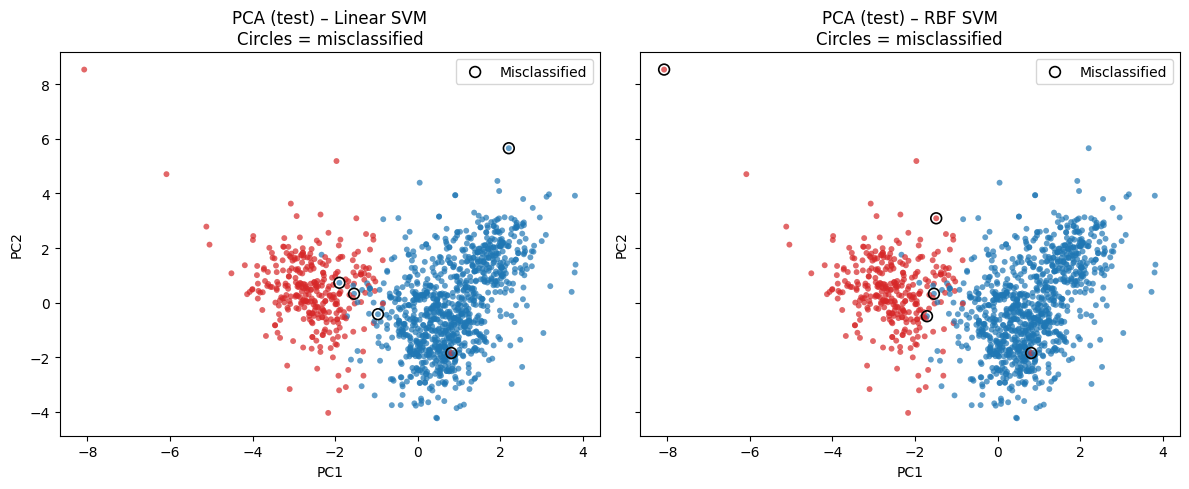

In [83]:
# 2D-projektion (fit på train för att undvika läckage)
pca = PCA(n_components=2, random_state=42)
Z_train = pca.fit_transform(X_train_scaled)
Z_test  = pca.transform(X_test_scaled)

# Masker för felklassificeringar
mis_lin = (y_pred_lin != y_test.values)
mis_rbf = (y_pred_rbf != y_test.values)

# Färger: 0=red, 1=white
colors = np.where(y_test.values==0, "tab:red", "tab:blue")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# --- Linear ---
axes[0].scatter(Z_test[:,0], Z_test[:,1], c=colors, s=18, alpha=0.7, edgecolor="none")
axes[0].scatter(Z_test[mis_lin,0], Z_test[mis_lin,1], facecolors="none", edgecolors="k", s=60, linewidths=1.2, label="Misclassified")
axes[0].set_title("PCA (test) – Linear SVM\nCircles = misclassified")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
axes[0].legend(loc="upper right")

# --- RBF ---
axes[1].scatter(Z_test[:,0], Z_test[:,1], c=colors, s=18, alpha=0.7, edgecolor="none")
axes[1].scatter(Z_test[mis_rbf,0], Z_test[mis_rbf,1], facecolors="none", edgecolors="k", s=60, linewidths=1.2, label="Misclassified")
axes[1].set_title("PCA (test) – RBF SVM\nCircles = misclassified")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

#### b) Decision boundaries

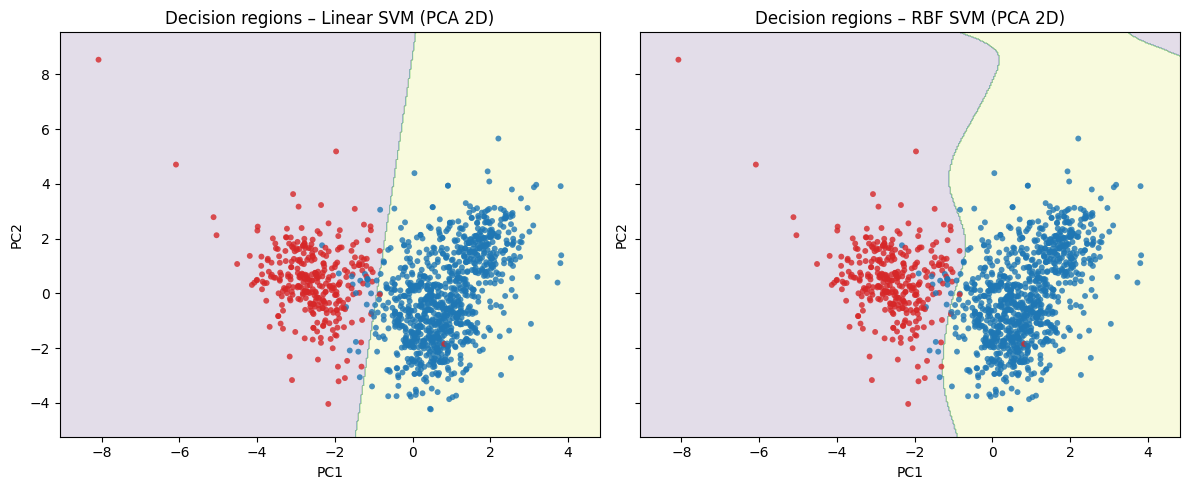

In [84]:
# Hämta parametrar från dina tidigare SVM:er
# Linear
C_lin = getattr(linear_svm, "C", 1)
cw_lin = getattr(linear_svm, "class_weight", "balanced")

# RBF (om du körde GridSearchCV)
if hasattr(rbf_svm, "best_params_"):
    C_rbf = rbf_svm.best_params_.get("C", 1)
    gamma_rbf = rbf_svm.best_params_.get("gamma", "scale")
else:
    C_rbf = getattr(rbf_svm, "C", 1)
    gamma_rbf = getattr(rbf_svm, "gamma", "scale")
cw_rbf = "balanced"  # som tidigare

# Träna om på 2D-PCA (train)
lin2 = SVC(kernel="linear", C=C_lin, class_weight=cw_lin, random_state=42).fit(Z_train, y_train)
rbf2 = SVC(kernel="rbf", C=C_rbf, gamma=gamma_rbf, class_weight=cw_rbf, random_state=42).fit(Z_train, y_train)

# Meshgrid över PCA-planet
x_min, x_max = Z_test[:,0].min()-1, Z_test[:,0].max()+1
y_min, y_max = Z_test[:,1].min()-1, Z_test[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]

# Pred på grid
zz_lin = lin2.predict(grid).reshape(xx.shape)
zz_rbf = rbf2.predict(grid).reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Linear decision region
axes[0].contourf(xx, yy, zz_lin, alpha=0.15)
axes[0].scatter(Z_test[:,0], Z_test[:,1], c=colors, s=18, alpha=0.8, edgecolor="none")
axes[0].set_title("Decision regions – Linear SVM (PCA 2D)")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

# RBF decision region
axes[1].contourf(xx, yy, zz_rbf, alpha=0.15)
axes[1].scatter(Z_test[:,0], Z_test[:,1], c=colors, s=18, alpha=0.8, edgecolor="none")
axes[1].set_title("Decision regions – RBF SVM (PCA 2D)")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

#### c) Top features

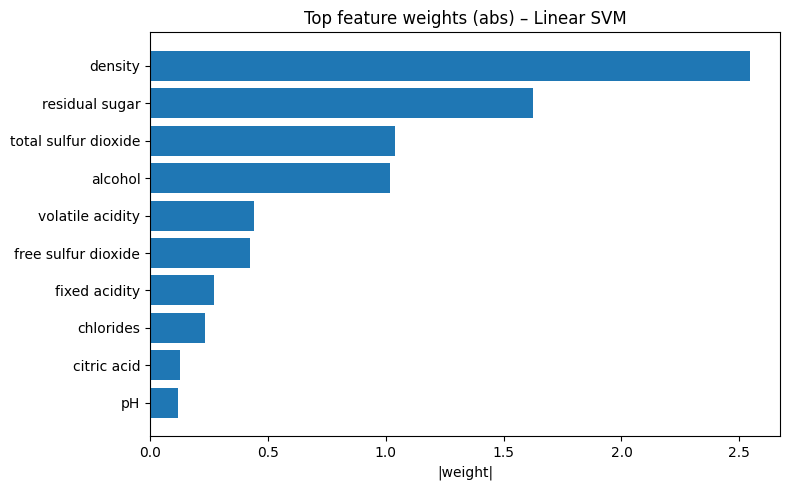

,feature,weight,abs_weight
7,density,-2.545292,2.545292
3,residual sugar,1.624481,1.624481
6,total sulfur dioxide,1.038878,1.038878
10,alcohol,-1.018446,1.018446
1,volatile acidity,-0.442555,0.442555
5,free sulfur dioxide,-0.425225,0.425225
0,fixed acidity,0.269621,0.269621
4,chlorides,-0.232715,0.232715
2,citric acid,0.127478,0.127478
8,pH,0.117104,0.117104


In [85]:
# linear_svm tränades på X_train_scaled → coef_ gäller de standardiserade features
w = linear_svm.coef_.ravel()
feat_names = X.columns
coef_df = pd.DataFrame({"feature": feat_names, "weight": w, "abs_weight": np.abs(w)})
coef_df = coef_df.sort_values("abs_weight", ascending=False)

topk = 10
plt.figure(figsize=(8, 5))
plt.barh(coef_df.head(topk)["feature"][::-1], coef_df.head(topk)["abs_weight"][::-1])
plt.title("Top feature weights (abs) – Linear SVM")
plt.xlabel("|weight|")
plt.tight_layout()
plt.show()

coef_df.head(15)

## Three class case

### 1. Create three classes

In [86]:
# (A) Fixed bins (interpretable)
# 3–4 = low, 5–6 = medium, 7–9 = high
def label_quality_fixed(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3_fixed"] = df["quality"].apply(label_quality_fixed)

# (B) Quantile bins (often more balanced)
q_edges = df["quality"].quantile([0, 1/3, 2/3, 1]).to_numpy()
labels_q = ["low_q", "mid_q", "high_q"]
df["quality_3_quant"] = pd.cut(
    df["quality"],
    bins=[-np.inf, q_edges[1], q_edges[2], np.inf],
    labels=labels_q,
    include_lowest=True
)

print("Counts (fixed):")
print(df["quality_3_fixed"].value_counts().sort_index())
print("\nCounts (quantile):")
print(df["quality_3_quant"].value_counts().sort_index())

# --- choose target column here ---
target_col = "quality_3_fixed"   # or "quality_3_quant"

Counts (fixed):
quality_3_fixed
high      1277
low        246
medium    4974
Name: count, dtype: int64

Counts (quantile):
quality_3_quant
low_q     2384
mid_q     2836
high_q    1277
Name: count, dtype: int64


### 2. Prepare train/test split

In [87]:
# === Prepare X, y, split (stratified) ===
from sklearn.model_selection import train_test_split

# Include 'type' as a categorical feature? (can help quality classification)
INCLUDE_TYPE = True

# Numeric base features (exclude original 'quality')
X_num = df.select_dtypes(include=[np.number]).drop(columns=["quality"], errors="ignore")

if INCLUDE_TYPE and "type" in df.columns:
    X = pd.concat([X_num, pd.get_dummies(df["type"], prefix="type", drop_first=False)], axis=1)
else:
    X = X_num.copy()

y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts().to_dict(), y_test.value_counts().to_dict()


((5197, 13),
 (1300, 13),
 {'medium': 3979, 'high': 1021, 'low': 197},
 {'medium': 995, 'high': 256, 'low': 49})

### 3. Linear SVM

In [88]:
# === Linear SVM (OvR) with probability for log-loss ===
lin_svm_ovr = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(
        SVC(kernel="linear", C=1, class_weight="balanced", probability=True, random_state=42)
    )
)

lin_svm_ovr.fit(X_train, y_train)
y_pred_lin = lin_svm_ovr.predict(X_test)
y_proba_lin = lin_svm_ovr.predict_proba(X_test)

print("=== Linear SVM (OvR, 3-class) ===")
print(confusion_matrix(y_test, y_pred_lin))
print(classification_report(y_test, y_pred_lin))

# Note: SVM trains per-class hinge losses (OvR). We can still report cross-entropy on calibrated probs.
ce_lin = log_loss(y_test, y_proba_lin, labels=lin_svm_ovr.named_steps["onevsrestclassifier"].classes_)
print(f"Cross-entropy (log-loss): {ce_lin:.4f}")



=== Linear SVM (OvR, 3-class) ===
[[203   6  47]
 [  8  17  24]
 [295  89 611]]
              precision    recall  f1-score   support

        high       0.40      0.79      0.53       256
         low       0.15      0.35      0.21        49
      medium       0.90      0.61      0.73       995

    accuracy                           0.64      1300
   macro avg       0.48      0.58      0.49      1300
weighted avg       0.77      0.64      0.67      1300

Cross-entropy (log-loss): 0.5268


### 4. RBF SVM

In [89]:
# === RBF SVM (OvR) with probability + optional tuning ===
from sklearn.model_selection import GridSearchCV

rbf_base = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(
        SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42)
    )
)

# Small grid (expand if you want)
param_grid = {
    "onevsrestclassifier__estimator__C": [0.5, 1, 5, 10],
    "onevsrestclassifier__estimator__gamma": ["scale", 0.1, 0.01]
}

rbf_grid = GridSearchCV(
    rbf_base,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

rbf_grid.fit(X_train, y_train)
print("Best RBF params:", rbf_grid.best_params_)

y_pred_rbf = rbf_grid.predict(X_test)
y_proba_rbf = rbf_grid.predict_proba(X_test)

print("=== RBF SVM (OvR, 3-class) ===")
print(confusion_matrix(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))

ce_rbf = log_loss(y_test, y_proba_rbf, labels=rbf_grid.best_estimator_.named_steps["onevsrestclassifier"].classes_)
print(f"Cross-entropy (log-loss): {ce_rbf:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RBF params: {'onevsrestclassifier__estimator__C': 10, 'onevsrestclassifier__estimator__gamma': 0.1}
=== RBF SVM (OvR, 3-class) ===
[[214   3  39]
 [  4  15  30]
 [211  55 729]]
              precision    recall  f1-score   support

        high       0.50      0.84      0.62       256
         low       0.21      0.31      0.25        49
      medium       0.91      0.73      0.81       995

    accuracy                           0.74      1300
   macro avg       0.54      0.62      0.56      1300
weighted avg       0.81      0.74      0.75      1300

Cross-entropy (log-loss): 0.4719


### 5. Comparison

#### a) Misclassified points and Decision Boundaries

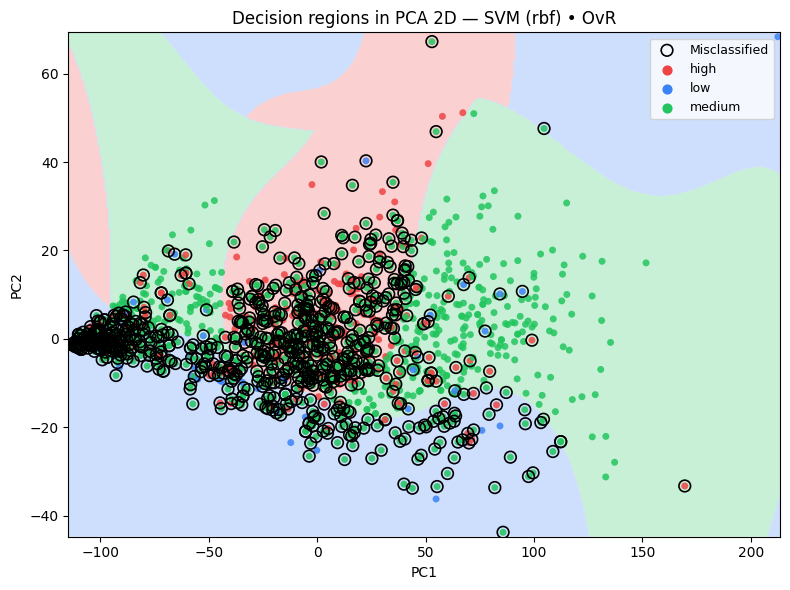

In [90]:
# ==== 1) PCA till 2D (fit på train för att undvika läckage) ====
pca = PCA(n_components=2, random_state=42)
Z_train = pca.fit_transform(X_train)   # X_train från din split
Z_test  = pca.transform(X_test)

# ==== 2) Etiketterna: mappa till heltal för modell + contourf ====
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # 0,1,2
y_test_enc  = le.transform(y_test)

# För referens:
classes = le.classes_  # t.ex. array(['high','low','medium'], dtype=object)

# ==== 3) Träna SVM i 2D för visualisering ====
KERNEL = "rbf"   # eller "linear"
svm2d = SVC(kernel=KERNEL, C=1, gamma="scale", class_weight="balanced",
            decision_function_shape="ovr", random_state=42)
svm2d.fit(Z_train, y_train_enc)

# ==== 4) Rutnät i PCA-planet ====
x_min, x_max = Z_test[:, 0].min() - 1, Z_test[:, 0].max() + 1
y_min, y_max = Z_test[:, 1].min() - 1, Z_test[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Prediktion på rutnätet (heltalsetiketter)
grid_pred_enc = svm2d.predict(grid).reshape(xx.shape)  # int array -> OK för contourf

# ==== 5) Färger och colormap ====
# Se till att vi har en färg per klass i rätt ordning (enligt encoder)
base_colors = ["#EF4444", "#3B82F6", "#22C55E"]  # röd, blå, grön (justera vid behov)
cmap = ListedColormap(base_colors[:len(classes)])
norm = BoundaryNorm(boundaries=np.arange(-0.5, len(classes)+0.5, 1), ncolors=len(classes))

# ==== 6) Rita beslutsregioner + testpunkter + markera fel ====
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_pred_enc, cmap=cmap, norm=norm, alpha=0.25, antialiased=True)

# Testpunkter färgkodas efter sant klassindex
plt.scatter(Z_test[:, 0], Z_test[:, 1], c=y_test_enc, cmap=cmap, norm=norm,
            s=25, edgecolors="none", alpha=0.85)

# Markera felklassificeringar
test_pred_enc = svm2d.predict(Z_test)
mis_mask = (test_pred_enc != y_test_enc)
plt.scatter(Z_test[mis_mask, 0], Z_test[mis_mask, 1],
            facecolors="none", edgecolors="k", s=70, linewidths=1.2, label="Misclassified")

# Legend med riktiga klassnamn (en prick per klassnamn)
for k, cls_name in enumerate(classes):
    plt.scatter([], [], c=base_colors[k], s=40, label=str(cls_name))

plt.title(f"Decision regions in PCA 2D — SVM ({KERNEL}) • OvR")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.show()

#### b) Top features Linear SVM

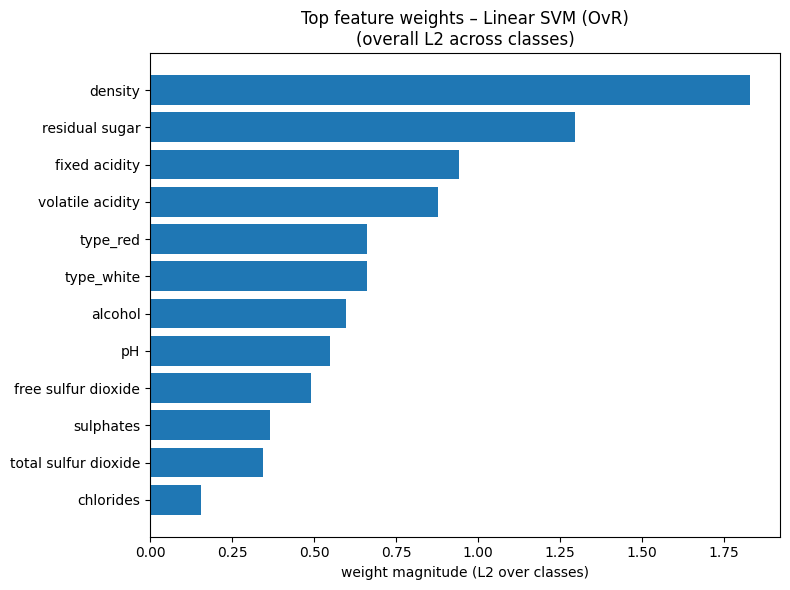

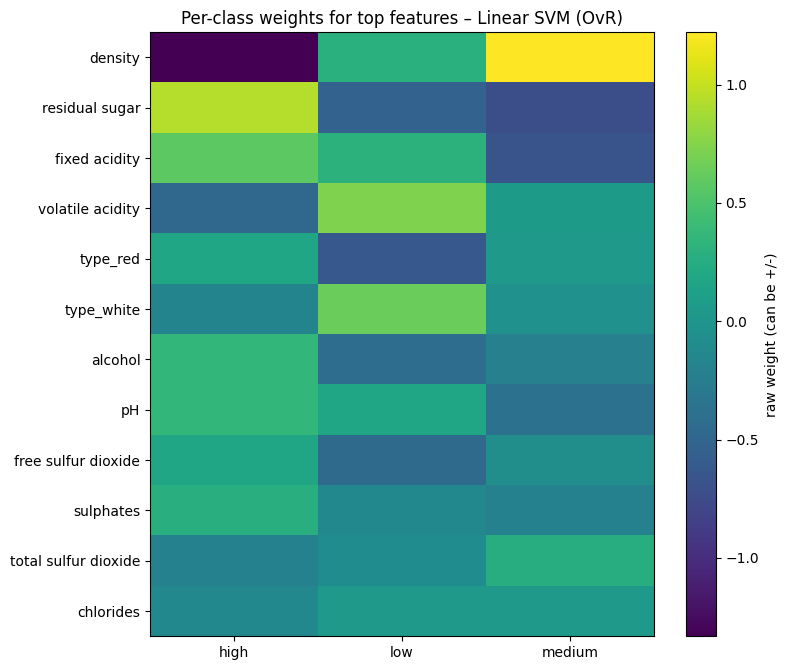

,high,low,medium
density,-1.331518,0.292839,1.220721
residual sugar,0.938613,-0.526829,-0.720695
fixed acidity,0.582028,0.310106,-0.671379
volatile acidity,-0.480888,0.730660,0.064163
type_red,0.183061,-0.632892,0.041728
type_white,-0.183061,0.632892,-0.041728
alcohol,0.362880,-0.422550,-0.216250
pH,0.355626,0.164208,-0.383166
free sulfur dioxide,0.178311,-0.451497,-0.072231
sulphates,0.266735,-0.144838,-0.205661


In [91]:
# === Hämta koefficienter från Linear SVM (OvR) ===
ovr = lin_svm_ovr.named_steps["onevsrestclassifier"]  # din tränade pipeline
classes = ovr.classes_
estimators = ovr.estimators_  # en linjär SVM per klass (binär)
feature_names = X.columns

# Stacka koefficienter: shape = (n_classes, n_features)
coefs = np.vstack([est.coef_.ravel() for est in estimators])   # rad = klass, kolumn = feature
df_w = pd.DataFrame(coefs.T, index=feature_names, columns=classes)

# --- Overall-importance: L2-norm över klasser (robust för multiclass) ---
overall = pd.Series(np.linalg.norm(df_w.values, axis=1), index=feature_names, name="overall_L2")

# Rita topp-k
TOPK = 12
top_overall = overall.sort_values(ascending=False).head(TOPK)

plt.figure(figsize=(8, 6))
plt.barh(top_overall.index[::-1], top_overall.values[::-1])
plt.title("Top feature weights – Linear SVM (OvR)\n(overall L2 across classes)")
plt.xlabel("weight magnitude (L2 over classes)")
plt.tight_layout()
plt.show()

# --- (Valfritt) Heatmap för per-klass vikter på samma topplista ---
df_top = df_w.loc[top_overall.index]
plt.figure(figsize=(8, 0.4*len(df_top)+2))
im = plt.imshow(df_top.values, aspect="auto")
plt.yticks(range(len(df_top.index)), df_top.index)
plt.xticks(range(len(df_top.columns)), df_top.columns, rotation=0)
plt.colorbar(label="raw weight (can be +/-)")
plt.title("Per-class weights for top features – Linear SVM (OvR)")
plt.tight_layout()
plt.show()

df_top  # praktiskt att ha i tabell också

#### c) RBF SVM

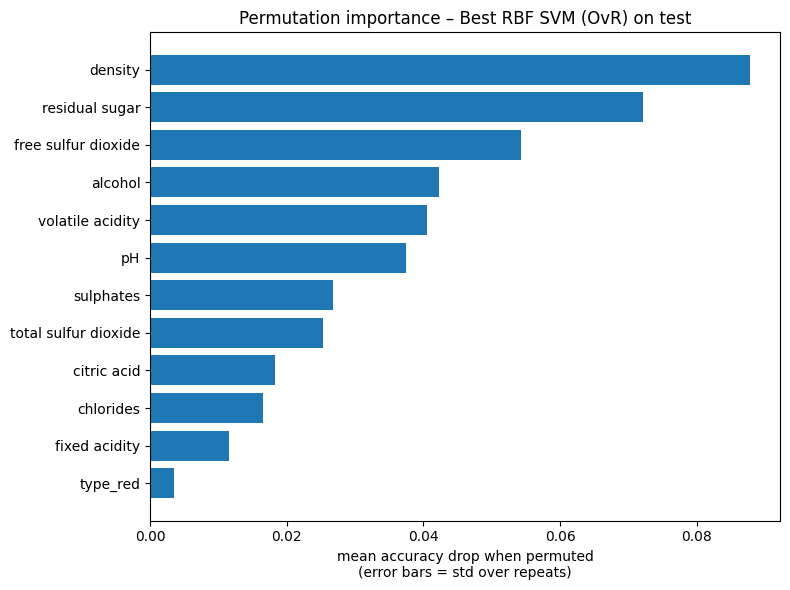

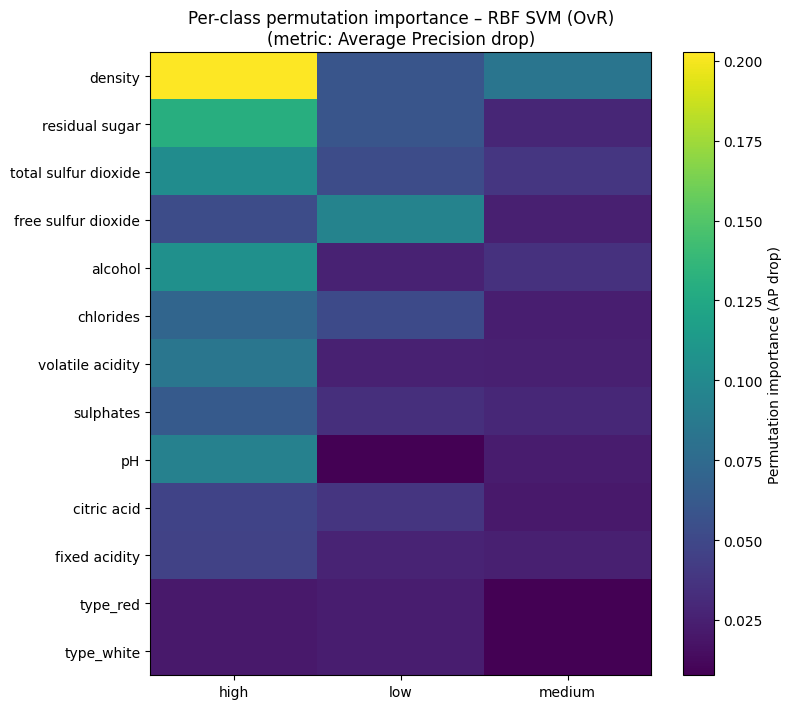

,high,low,medium
density,0.202763,0.059028,0.083696
residual sugar,0.130137,0.058738,0.028785
total sulfur dioxide,0.102411,0.053203,0.038866
free sulfur dioxide,0.053157,0.094768,0.024932
alcohol,0.105477,0.026672,0.035509
chlorides,0.071195,0.051246,0.023883
volatile acidity,0.084056,0.025616,0.024640
sulphates,0.063281,0.033614,0.029678
pH,0.093268,0.008194,0.022224
citric acid,0.046611,0.037608,0.021195


In [92]:
# 1) Hämta bästa pipeline (scaler + OneVsRest(SVC))
rbf_model = rbf_grid.best_estimator_   # <- detta är din tränade bästa RBF-pipeline

# 2) Kör permutation importance på testdata
#    Tips: öka n_repeats för mer stabilt resultat (tar längre tid)
result = permutation_importance(
    rbf_model,
    X_test, y_test,
    scoring="accuracy",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 3) Bygg en snygg tabell
imp = pd.Series(result.importances_mean, index=X.columns, name="perm_importance")
imp_std = pd.Series(result.importances_std, index=X.columns, name="std")

TOPK = 12
top_imp = imp.sort_values(ascending=False).head(TOPK)

# 4) Rita
plt.figure(figsize=(8, 6))
plt.barh(top_imp.index[::-1], top_imp.values[::-1])
        #xerr=imp_std.loc[top_imp.index][::-1].values)
plt.title("Permutation importance – Best RBF SVM (OvR) on test")
plt.xlabel("mean accuracy drop when permuted\n(error bars = std over repeats)")
plt.tight_layout()
plt.show()

# 5) Visa tabell
pd.concat([top_imp, imp_std.loc[top_imp.index]], axis=1)




#HEATMAP

# 1) Hämta bästa RBF-modell (pipeline) från din GridSearch
rbf_model = rbf_grid.best_estimator_

# 2) Hjälpfunktion: class-wise scorer (OvR) med Average Precision
def ap_scorer_for_class(estimator, X, y, target_class):
    """
    OvR Average Precision för en given klass.
    y är multiclass (pandas Series eller array med label-strängar).
    """
    # Hämta klasser och index för target_class
    classes = estimator.named_steps["onevsrestclassifier"].classes_
    # sannolikheter för alla klasser
    proba = estimator.predict_proba(X)
    # binär ground truth för klassen
    y_bin = (np.array(y) == target_class).astype(int)
    # kolumnindex för klassen i proba
    j = np.where(classes == target_class)[0][0]
    return average_precision_score(y_bin, proba[:, j])

# 3) Loopa över klasser och beräkna permutation importance med class-wise scorer
classes = rbf_model.named_steps["onevsrestclassifier"].classes_
feat_names = X.columns
PI_mean = pd.DataFrame(0.0, index=feat_names, columns=classes)
PI_std  = pd.DataFrame(0.0, index=feat_names, columns=classes)

N_REPEATS = 20     # öka för stabilare staplar (tar längre tid)
N_JOBS    = -1

for cls in classes:
    # scorer som låser klassen
    scorer = partial(ap_scorer_for_class, target_class=cls)
    # permutation importance för just den klassen
    res = permutation_importance(
        rbf_model, X_test, y_test,
        scoring=scorer,
        n_repeats=N_REPEATS,
        random_state=42,
        n_jobs=N_JOBS
    )
    PI_mean[cls] = res.importances_mean
    PI_std[cls]  = res.importances_std

# 4) (Valfritt) sortera features globalt efter total importance
order = PI_mean.mean(axis=1).sort_values(ascending=False).index
PI_mean_sorted = PI_mean.loc[order]

# 5) Rita heatmap (matplotlib)
plt.figure(figsize=(8, 0.4*len(PI_mean_sorted)+2))
im = plt.imshow(PI_mean_sorted.values, aspect="auto", cmap="viridis")
plt.colorbar(im, label="Permutation importance (AP drop)")
plt.yticks(range(len(PI_mean_sorted.index)), PI_mean_sorted.index)
plt.xticks(range(len(classes)), classes)
plt.title("Per-class permutation importance – RBF SVM (OvR)\n(metric: Average Precision drop)")
plt.tight_layout()
plt.show()

# Visa tabellen också (topp 15)
PI_mean_sorted.head(15)


